In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

# https://github.com/BelBES/crnn-pytorch

# 生成训练数据

In [28]:
import lib.data.gen_data as gd
import lib.data.dataset as ds
import lib.data.char as char
import importlib
importlib.reload(gd)
importlib.reload(char)

# 生成文字图片
gd.create_data(1000)

# 根据生成文字图片，保存到lmdb
ds.main_create_data()

...................
Written 1000 / 1438
Created dataset with 1438 samples


# 加载训练数据

In [2]:
import lib.data.lmdb_dataset as lds
import torch
train_path = '/home/hecong/temp/data/ocr/lmdb'
batchSize = 10
sampler = None
workers = 1
imgH = 32
imgW = 256

train_dataset = lds.lmdbDataset(root=train_path)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batchSize,
    shuffle=True,
    sampler=sampler,
    num_workers=int(workers),
    collate_fn=lds.alignCollate(imgH=imgH, imgW=imgW, keep_ratio=True))

('洁洪洒浇浊洞测洗活派', '狡狱狠贸怨急饶蚀饺饼', '羽观欢买红纤级约纪驰', '夕丸么广亡门义之尸弓', '勉狭狮独狡狱狠贸怨急')


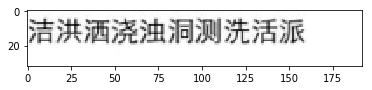

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
_,(image,label) = next(enumerate(train_loader))
image_0 = image[0][0]
image_0 = image_0.numpy()
print(label)
plt.imshow(image_0,'gray')
plt.show()


# 模型

In [3]:
import torch.nn as nn
import torch.nn.parallel

# custom weights initialization called on crnn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def data_parallel(model, input, ngpu):
    if ngpu > 1 and isinstance(input.data, torch.cuda.FloatTensor):
        output = nn.parallel.data_parallel(model, input, range(ngpu))
    else:
        output = model(input)
    return output
    
class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut, ngpu):
        super(BidirectionalLSTM, self).__init__()
        self.ngpu = ngpu
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = data_parallel(self.rnn, input,
                                           self.ngpu)  # [T, b, h * 2]
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = data_parallel(self.embedding, 
                               t_rec,self.ngpu)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh, ngpu, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        self.ngpu = ngpu
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))
                                                                    
        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        # pool = nn.MaxPool2d(kernel_size=2, stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        # 注意MaxPool2d 当stride = (2,1),表示只会根据H轴方向进行Pool，因为W方向是1。
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh, ngpu),
            BidirectionalLSTM(nh, nh, nclass, ngpu))

    def forward(self, input):
        # conv features
#         print('input size --> {}'.format(input.size()))
        conv = data_parallel(self.cnn, input, self.ngpu)
        b, c, h, w = conv.size()
#         print('conv out size --> {}'.format(conv.size()))
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        
        # rnn features
        output = data_parallel(self.rnn, conv, self.ngpu)
        return output


# 训练

In [10]:
import lib.data.char as c
from warpctc_pytorch import CTCLoss
import lib.utils as utils
import torch.optim as optim
import os
import importlib
importlib.reload(utils)


ngpu = 0
# size of the lstm hidden state
nh = 256
nclass = len(c.alphabet) + 1
# input channel ， 因为训练图片是转成灰度图，所以该值为1
nc = 1
lr = 0.001
beta1=0.5
MOMENTUM = 0.9
EPOCH = 100




# 字符转换编码
converter = utils.strLabelConverter(c.alphabet)
# 损失函数
criterion = CTCLoss()

crnn = CRNN(imgH, nc, nclass, nh, ngpu)
crnn.apply(weights_init)
if os.path.exists('/home/hecong/temp/data/ocr/simple_ocr.pkl'):
    crnn.load_state_dict(torch.load('/home/hecong/temp/data/ocr/simple_ocr.pkl'))

image = torch.FloatTensor(batchSize, 3, imgH, imgH)
text = torch.IntTensor(batchSize * 5)
length = torch.IntTensor(batchSize)

# optimizer = optim.Adam(
#     crnn.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer = optim.SGD(
    crnn.parameters(), lr=lr, momentum=MOMENTUM)

for epoch in range(EPOCH):
    for step,(t_image,t_label) in enumerate(train_loader):
        batch_size = t_image.size(0)
        utils.loadData(image, t_image)
        t, l = converter.encode(t_label)
        utils.loadData(text, t)
        utils.loadData(length, l)
        preds = crnn(image)
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        optimizer.zero_grad()
        cost = criterion(preds, text, preds_size, length) / batch_size
        cost.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print('{}:{} loss --> {}'.format(epoch, step, cost))
            torch.save(crnn.state_dict(), '/home/hecong/temp/data/ocr/simple_ocr.pkl')

0:0 loss --> tensor([2.0093], grad_fn=<DivBackward0>)
0:10 loss --> tensor([50.4357], grad_fn=<DivBackward0>)
0:20 loss --> tensor([32.7192], grad_fn=<DivBackward0>)
0:30 loss --> tensor([29.6999], grad_fn=<DivBackward0>)
0:40 loss --> tensor([30.8185], grad_fn=<DivBackward0>)
0:50 loss --> tensor([17.9923], grad_fn=<DivBackward0>)
0:60 loss --> tensor([21.9073], grad_fn=<DivBackward0>)
0:70 loss --> tensor([19.4085], grad_fn=<DivBackward0>)
0:80 loss --> tensor([14.9581], grad_fn=<DivBackward0>)
0:90 loss --> tensor([10.8917], grad_fn=<DivBackward0>)
0:100 loss --> tensor([17.9379], grad_fn=<DivBackward0>)
0:110 loss --> tensor([29.3240], grad_fn=<DivBackward0>)
0:120 loss --> tensor([28.2609], grad_fn=<DivBackward0>)
0:130 loss --> tensor([18.1639], grad_fn=<DivBackward0>)
0:140 loss --> tensor([18.5935], grad_fn=<DivBackward0>)
1:0 loss --> tensor([10.9817], grad_fn=<DivBackward0>)
1:10 loss --> tensor([28.2779], grad_fn=<DivBackward0>)
1:20 loss --> tensor([12.5013], grad_fn=<DivBa

9:130 loss --> tensor([1.2131], grad_fn=<DivBackward0>)
9:140 loss --> tensor([2.1582], grad_fn=<DivBackward0>)
10:0 loss --> tensor([0.7925], grad_fn=<DivBackward0>)
10:10 loss --> tensor([1.0252], grad_fn=<DivBackward0>)
10:20 loss --> tensor([0.9202], grad_fn=<DivBackward0>)
10:30 loss --> tensor([2.2983], grad_fn=<DivBackward0>)
10:40 loss --> tensor([1.7586], grad_fn=<DivBackward0>)
10:50 loss --> tensor([1.0025], grad_fn=<DivBackward0>)
10:60 loss --> tensor([1.1002], grad_fn=<DivBackward0>)
10:70 loss --> tensor([1.6339], grad_fn=<DivBackward0>)
10:80 loss --> tensor([1.1685], grad_fn=<DivBackward0>)
10:90 loss --> tensor([1.7231], grad_fn=<DivBackward0>)
10:100 loss --> tensor([1.5969], grad_fn=<DivBackward0>)
10:110 loss --> tensor([1.5072], grad_fn=<DivBackward0>)
10:120 loss --> tensor([1.4141], grad_fn=<DivBackward0>)
10:130 loss --> tensor([0.9110], grad_fn=<DivBackward0>)
10:140 loss --> tensor([0.9626], grad_fn=<DivBackward0>)
11:0 loss --> tensor([1.0419], grad_fn=<DivB

19:90 loss --> tensor([0.2520], grad_fn=<DivBackward0>)
19:100 loss --> tensor([0.4761], grad_fn=<DivBackward0>)
19:110 loss --> tensor([0.4002], grad_fn=<DivBackward0>)
19:120 loss --> tensor([0.2502], grad_fn=<DivBackward0>)
19:130 loss --> tensor([0.3875], grad_fn=<DivBackward0>)
19:140 loss --> tensor([0.4349], grad_fn=<DivBackward0>)
20:0 loss --> tensor([0.2993], grad_fn=<DivBackward0>)
20:10 loss --> tensor([0.2748], grad_fn=<DivBackward0>)
20:20 loss --> tensor([0.3232], grad_fn=<DivBackward0>)
20:30 loss --> tensor([0.2080], grad_fn=<DivBackward0>)
20:40 loss --> tensor([0.6131], grad_fn=<DivBackward0>)
20:50 loss --> tensor([0.2125], grad_fn=<DivBackward0>)
20:60 loss --> tensor([0.3636], grad_fn=<DivBackward0>)
20:70 loss --> tensor([0.1854], grad_fn=<DivBackward0>)
20:80 loss --> tensor([0.1873], grad_fn=<DivBackward0>)
20:90 loss --> tensor([0.2647], grad_fn=<DivBackward0>)
20:100 loss --> tensor([0.2375], grad_fn=<DivBackward0>)
20:110 loss --> tensor([0.2226], grad_fn=<D

29:50 loss --> tensor([0.1220], grad_fn=<DivBackward0>)
29:60 loss --> tensor([0.1549], grad_fn=<DivBackward0>)
29:70 loss --> tensor([0.1106], grad_fn=<DivBackward0>)
29:80 loss --> tensor([0.1326], grad_fn=<DivBackward0>)
29:90 loss --> tensor([0.1022], grad_fn=<DivBackward0>)
29:100 loss --> tensor([0.2556], grad_fn=<DivBackward0>)
29:110 loss --> tensor([0.0985], grad_fn=<DivBackward0>)
29:120 loss --> tensor([0.1253], grad_fn=<DivBackward0>)
29:130 loss --> tensor([0.1685], grad_fn=<DivBackward0>)
29:140 loss --> tensor([0.2129], grad_fn=<DivBackward0>)
30:0 loss --> tensor([0.3538], grad_fn=<DivBackward0>)
30:10 loss --> tensor([0.1281], grad_fn=<DivBackward0>)
30:20 loss --> tensor([0.1093], grad_fn=<DivBackward0>)
30:30 loss --> tensor([0.1004], grad_fn=<DivBackward0>)
30:40 loss --> tensor([0.1302], grad_fn=<DivBackward0>)
30:50 loss --> tensor([0.2209], grad_fn=<DivBackward0>)
30:60 loss --> tensor([0.2022], grad_fn=<DivBackward0>)
30:70 loss --> tensor([0.1259], grad_fn=<Div

39:10 loss --> tensor([0.1860], grad_fn=<DivBackward0>)
39:20 loss --> tensor([0.0797], grad_fn=<DivBackward0>)
39:30 loss --> tensor([0.0885], grad_fn=<DivBackward0>)
39:40 loss --> tensor([0.1416], grad_fn=<DivBackward0>)
39:50 loss --> tensor([0.1131], grad_fn=<DivBackward0>)
39:60 loss --> tensor([0.1277], grad_fn=<DivBackward0>)
39:70 loss --> tensor([0.0795], grad_fn=<DivBackward0>)
39:80 loss --> tensor([0.0667], grad_fn=<DivBackward0>)
39:90 loss --> tensor([0.1610], grad_fn=<DivBackward0>)
39:100 loss --> tensor([0.0903], grad_fn=<DivBackward0>)
39:110 loss --> tensor([0.0821], grad_fn=<DivBackward0>)
39:120 loss --> tensor([0.0649], grad_fn=<DivBackward0>)
39:130 loss --> tensor([0.1426], grad_fn=<DivBackward0>)
39:140 loss --> tensor([0.0893], grad_fn=<DivBackward0>)
40:0 loss --> tensor([0.0796], grad_fn=<DivBackward0>)
40:10 loss --> tensor([0.1631], grad_fn=<DivBackward0>)
40:20 loss --> tensor([0.1261], grad_fn=<DivBackward0>)
40:30 loss --> tensor([0.0960], grad_fn=<Div

48:120 loss --> tensor([0.1019], grad_fn=<DivBackward0>)
48:130 loss --> tensor([0.1465], grad_fn=<DivBackward0>)
48:140 loss --> tensor([0.0457], grad_fn=<DivBackward0>)
49:0 loss --> tensor([0.0611], grad_fn=<DivBackward0>)
49:10 loss --> tensor([0.1714], grad_fn=<DivBackward0>)
49:20 loss --> tensor([0.0749], grad_fn=<DivBackward0>)
49:30 loss --> tensor([0.1451], grad_fn=<DivBackward0>)
49:40 loss --> tensor([0.0926], grad_fn=<DivBackward0>)
49:50 loss --> tensor([0.0763], grad_fn=<DivBackward0>)
49:60 loss --> tensor([0.0895], grad_fn=<DivBackward0>)
49:70 loss --> tensor([0.0620], grad_fn=<DivBackward0>)
49:80 loss --> tensor([0.0934], grad_fn=<DivBackward0>)
49:90 loss --> tensor([0.0709], grad_fn=<DivBackward0>)
49:100 loss --> tensor([0.1125], grad_fn=<DivBackward0>)
49:110 loss --> tensor([0.0861], grad_fn=<DivBackward0>)
49:120 loss --> tensor([0.0731], grad_fn=<DivBackward0>)
49:130 loss --> tensor([0.1325], grad_fn=<DivBackward0>)
49:140 loss --> tensor([0.1481], grad_fn=<

58:80 loss --> tensor([4.4251], grad_fn=<DivBackward0>)
58:90 loss --> tensor([2.0784], grad_fn=<DivBackward0>)
58:100 loss --> tensor([3.4789], grad_fn=<DivBackward0>)
58:110 loss --> tensor([2.0481], grad_fn=<DivBackward0>)
58:120 loss --> tensor([3.2647], grad_fn=<DivBackward0>)
58:130 loss --> tensor([2.9361], grad_fn=<DivBackward0>)
58:140 loss --> tensor([1.0645], grad_fn=<DivBackward0>)
59:0 loss --> tensor([1.4378], grad_fn=<DivBackward0>)
59:10 loss --> tensor([0.8588], grad_fn=<DivBackward0>)
59:20 loss --> tensor([1.3759], grad_fn=<DivBackward0>)
59:30 loss --> tensor([2.0949], grad_fn=<DivBackward0>)
59:40 loss --> tensor([0.6558], grad_fn=<DivBackward0>)
59:50 loss --> tensor([1.0538], grad_fn=<DivBackward0>)
59:60 loss --> tensor([0.8373], grad_fn=<DivBackward0>)
59:70 loss --> tensor([0.8074], grad_fn=<DivBackward0>)
59:80 loss --> tensor([0.9266], grad_fn=<DivBackward0>)
59:90 loss --> tensor([1.1950], grad_fn=<DivBackward0>)
59:100 loss --> tensor([0.8516], grad_fn=<Di

68:40 loss --> tensor([0.1940], grad_fn=<DivBackward0>)
68:50 loss --> tensor([0.1369], grad_fn=<DivBackward0>)
68:60 loss --> tensor([0.1075], grad_fn=<DivBackward0>)
68:70 loss --> tensor([0.1858], grad_fn=<DivBackward0>)
68:80 loss --> tensor([0.1167], grad_fn=<DivBackward0>)
68:90 loss --> tensor([0.9398], grad_fn=<DivBackward0>)
68:100 loss --> tensor([0.1030], grad_fn=<DivBackward0>)
68:110 loss --> tensor([0.0967], grad_fn=<DivBackward0>)
68:120 loss --> tensor([0.1802], grad_fn=<DivBackward0>)
68:130 loss --> tensor([0.1276], grad_fn=<DivBackward0>)
68:140 loss --> tensor([0.4271], grad_fn=<DivBackward0>)
69:0 loss --> tensor([0.2381], grad_fn=<DivBackward0>)
69:10 loss --> tensor([0.1186], grad_fn=<DivBackward0>)
69:20 loss --> tensor([0.1660], grad_fn=<DivBackward0>)
69:30 loss --> tensor([0.2088], grad_fn=<DivBackward0>)
69:40 loss --> tensor([0.1419], grad_fn=<DivBackward0>)
69:50 loss --> tensor([0.1348], grad_fn=<DivBackward0>)
69:60 loss --> tensor([0.1773], grad_fn=<Div

Process Process-91:
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
Traceback (most recent call last):
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hecong/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/home/hecong/tools/python3/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(

KeyboardInterrupt: 

In [67]:
# preds_size = torch.IntTensor([49])
# length = torch.IntTensor([2])
print(preds.size())
print(text.size())
print(text)
print(preds_size)
print(length)

criterion(preds, text, preds_size, length)

# prob size --> torch.Size([2, 1, 5])
# labels size --> torch.Size([2])
# prob sizes -->tensor([2], dtype=torch.int32)
# label sizes -->tensor([2], dtype=torch.int32)

torch.Size([49, 1, 42])
torch.Size([10])
tensor([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], dtype=torch.int32)
tensor([49], dtype=torch.int32)
tensor([1], dtype=torch.int32)


tensor([12.0142], grad_fn=<_CTCBackward>)

In [7]:
torch.save(crnn.state_dict(), '/home/hecong/temp/data/ocr/simple_ocr.pkl')

# 检验

In [11]:
import lib.data.char as c
import lib.utils as utils
import os
import importlib
importlib.reload(utils)


ngpu = 0
# size of the lstm hidden state
nh = 256
nclass = len(c.alphabet) + 1
# input channel ， 因为训练图片是转成灰度图，所以该值为1
nc = 1
lr = 0.001
beta1=0.5
converter = utils.strLabelConverter(c.alphabet)

crnn = CRNN(imgH, nc, nclass, nh, ngpu)
crnn.apply(weights_init)
if os.path.exists('/home/hecong/temp/data/ocr/simple_ocr.pkl'):
    crnn.load_state_dict(torch.load('/home/hecong/temp/data/ocr/simple_ocr.pkl'))
image = torch.FloatTensor(batchSize, 3, imgH, imgH)
_,(v_image,v_text) = next(enumerate(train_loader))
utils.loadData(image,v_image)
preds_s = crnn(image)
batch_size = v_image.size(0)
preds_size = Variable(torch.IntTensor([preds_s.size(0)] * batch_size))


torch.Size([10, 49, 1441])
tensor([1296,    0, 1297, 1297,    0,    0,    0, 1298, 1299, 1299,    0,    0,
           0, 1300, 1300, 1300,    0,    0,    0,    0, 1301, 1301, 1301, 1301,
        1301, 1302, 1302, 1303, 1304, 1304,    0,    0,    0,    0,    0,    0,
           0, 1305, 1305,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   73,   73,   74,   74,    0,    0,   75,   75,   75,    0,
           0,    0,    0,    0,    0,    0,    0,   76,   77,    0,    0,    0,
          78,   79,   79,    0,    0,    0,   80,   80,   81,   81,    0,    0,
           0,    0,    0,   82,   82,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  819,  819,    0,    0,    0,    0,    0,    0,  820,
         820,  821,  821,  822,  822,  822,    0,  823,  823,    0,  824,  825,
         825,  826,  827,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  828,  828,  828,    0,    0,    0,    0,    0,    0,    0,
           0,

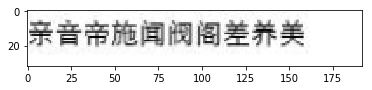

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


preds = preds_s.clone()

preds = preds.permute(1,0,2)
print(preds.size())
_,preds = preds.max(2)
preds = preds.view(-1)
print(preds)
preds_size = Variable(torch.IntTensor([preds_s.size(0)])) * batchSize
sim_preds = converter.decode(preds.data, preds_size.data, raw=False)

print(sim_preds)
image_0 = v_image[0][0]
image_0 = image_0.numpy()
plt.imshow(image_0,'gray')
plt.show()
